In [81]:
#DEV
import os
import glob
import numpy as np
from platform import system as OS
import pandas as pd
import tables as tb
import h5py
import scipy.stats
import datetime
from copy import deepcopy
from IPython.display import clear_output, display, HTML, Image
import matplotlib.cm as cm
import warnings

warnings.filterwarnings("ignore")
import sys
import pickle
import matplotlib.pyplot as plt

if OS() == 'Linux':
    root = "/data"
elif OS() == 'Windows':
    root = "C:\\DATA\\"
else:
    root = "/Users/davidrobbe/Documents/Data/"

param={
    "goalTime":7,#needed for pavel data only
    "treadmillRange":[0,90],#pavel error conversion "treadmillRange":[0,80]
    "maxTrialDuration":15,
    "interTrialDuration":10,#None pavel
    "endTrial_frontPos":30,
    "endTrial_backPos":55, 
    "endTrial_minTimeSec":4,
    "cameraSamplingRate":25, #needed for new setup    

    "sigmaSmoothPosition":0.1,#0.33, 0.18 pavel
    "sigmaSmoothSpeed":0.3,#0.3, 0.5 pavel
    "nbJumpMax":100,#200 pavel
    "binSize":0.25,
    #parameters used to preprocess (will override the default parameters)
}  
ThisNoteBookPath=os.path.dirname(os.path.realpath("__file__"))
CommonNoteBookesPath=os.path.join(os.path.split(ThisNoteBookPath)[0],"load_preprocess_rat")
CWD=os.getcwd()
os.chdir(CommonNoteBookesPath)
%run Animal_Tags.ipynb
%run UtilityTools.ipynb
%run BatchRatBehavior.ipynb
%run plotRat_documentation_3_KinematicsInvestigation.ipynb
%run plotRat_documentation_1_GeneralBehavior.ipynb
%run loadRat_documentation.ipynb
os.chdir(CWD)

#### ViewPoint intertrial analysis for Loco test

check normal exploration

In [504]:
def find_persistent_movement_epochs(pos: np.array, TH: int, treadmillStep: float =0):
    """
    this function finds epochs in the position of a single trial, pos, where the animal has moved
    for a duration of at least, TH*cameraSamplingRate
    pos: position as a np.array
    TH: an integer like: TH=int(0.2*data.cameraSamplingRate)
    treadmillStep: a float number to correct for treadmill movement, like:
        treadmillStep=np.expand_dims(data.treadmillSpeed[trial]/data.cameraSamplingRate,1)
    """
    
    dp=np.append(np.diff(pos)-treadmillStep,0)
    dp=dp>=0
    dp=dp*1
    dpcross=np.absolute( np.append(np.diff(dp),0)-np.append(0,np.diff(dp)) )
    #any 1 in dpcross mean a zero-crossing in diff(pos)
    crossindex=np.where(dpcross)[0]
    movementepoch=np.where(np.diff(crossindex)>TH)[0]

    posMoveIndex=np.empty(shape=(len(movementepoch),2))

    for i,index in enumerate(movementepoch):
        posMoveIndex[i,:]=(crossindex[index],crossindex[index+1])
        
    return posMoveIndex

def run_distance(data,trial=None):
    if trial is None:
        trial=list(data.position.keys())
    elif not hasattr(trial,'__iter__'):
        trial=[trial]
        
    dis=[0]
    for i in trial:
        et=(data.entranceTime[i]+data.cameraToTreadmillDelay)*data.cameraSamplingRate
        allTraj=data.position[i]
    #     allTraj=scipy.ndimage.filters.gaussian_filter1d(allTraj, sigma=data.cameraSamplingRate/5, truncate=3.0)
        if np.isnan(et):
            th=(data.maxTrialDuration[i]+data.cameraToTreadmillDelay)*data.cameraSamplingRate
            th=int(th)
        else:
            th=int(et)
        allTraj[th-1:]=np.nan
        treadmillStep=np.expand_dims(data.treadmillSpeed[i]/data.cameraSamplingRate,1)
        posMoveIndex=find_persistent_movement_epochs(allTraj,
                                                     TH=int(0.6*data.cameraSamplingRate),
                                                     treadmillStep=treadmillStep)

        for i,j in posMoveIndex:
            epochPos=allTraj[int(i):int(j)]
            dis[-1]+=np.nansum(np.absolute(np.diff(epochPos)-treadmillStep))
        dis.append(0)

    return np.array(dis[:-1])


In [499]:
animalList=['Rat325', 'Rat337', 'Rat341', 'Rat345']#, 'Rat329', 'Rat333']
profile={'Type':'Good',
         'rewardType':'Progressive',
#          'initialSpeed':'10',
#          'Speed':['10'],
         'Tag':'Reverse-Late_DLS-EXP'
         }
sessionList=batch_get_session_list(root,animalList,profile)['Sessions']

for session in sessionList:
    animal=session[:6]
    data=Data(root,session[:6],session,param=param,redoPreprocess=False, saveAsPickle=False);
    


136.07805986465104 speed:0.0


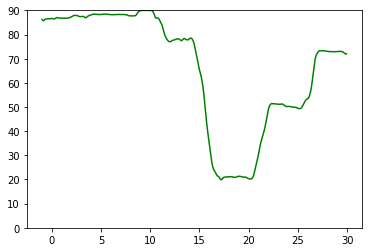

In [502]:
i=11
plt.plot(np.linspace(-1,30,len(data.position[i])),data.position[i],'g')
plt.ylim([0,90])
print(run_distance(data,i),f'speed:{data.treadmillSpeed[i]}')

In [123]:
len(data.maxTrialDuration),len(data.position),len(data.rawIntertrialPosition),len(data.treadmillSpeed)

(40, 40, 40, 40)

In [240]:
a=[]
treadmillStep=np.expand_dims(data.treadmillSpeed[i]/data.cameraSamplingRate,1)
dis=np.absolute(np.diff(scipy.ndimage.filters.gaussian_filter1d(
data.position[i], sigma=50, truncate=3.0))-treadmillStep)
a.extend(list(dis))



In [374]:
diffPos=np.diff(allTraj)

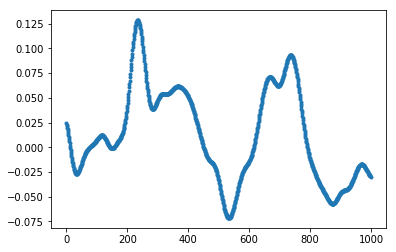

In [379]:
i=0
plt.plot(diffPos[i:i+1000],'.')

In [449]:
posMoveIndex=find_persistent_movement_epoch(pos, TH=40, treadmillStep=0)

In [512]:
session='Rat269_2018_09_03_11_38'
data=Data(root,session[:6],session,param=param,redoPreprocess=False, saveAsPickle=False);
np.mean(run_distance(data))

106.91099167670998

In [101]:
profile={'Type':'Good',
         'rewardType':'Progressive',
#          'initialSpeed':'10',
#          'Speed':['10'],
         'Tag':'Reverse'
         }

animalList=batch_get_animal_list(root,profile)
print(animalList)

['Rat325', 'Rat329', 'Rat333', 'Rat337', 'Rat341', 'Rat345', 'Rat365', 'Rat366', 'Rat367', 'Rat368', 'Rat370', 'Rat372']


In [148]:
session='Rat217_2018_04_23_11_42'
data=Data(root,session[:6],session,param=param,redoPreprocess=False, saveAsPickle=False);


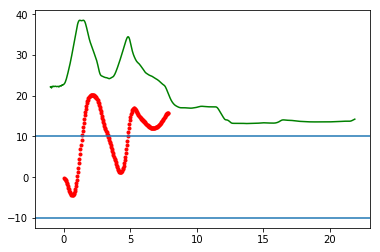

In [170]:
i=20
plt.plot(get_speed_treadmillON(data,i)[1],get_speed_treadmillON(data,i)[0],'r.')
plt.plot(data.timeTreadmill[i],data.position[i],'g')
plt.axhline(10)
plt.axhline(-10)
# plt.plot(data.timeBin,data.speedSmoothBin[i],'r')

In [116]:
speed,time=get_speed_treadmillON(data,i)

In [177]:
time[np.where(np.abs(speed)>10)[0][0]]

2.7000000000007276

In [191]:
session='Rat264_2018_07_13_14_39'
data=Data(root,session[:6],session,param=param,redoPreprocess=False, saveAsPickle=False);


In [187]:
seqTrials,_=sequential_trials(data)
len(seqTrials)/data.nTrial

0.36496350364963503

In [188]:
np.mean([min(data.speedSmoothBin[i]) for i in seqTrials])

-10.575994942835749

In [194]:
def waiting_time(data, xFront=30, speedTolerance=10):
    detect_trial_end(data,trials=data.position.keys())
    cs=int(data.cameraSamplingRate)
    trialStart=int(cs*data.cameraToTreadmillDelay)
    
    waitTrial=[]
    waitTime=[]
    for trial,pos in data.position.items():
        
        #starting from the front
        if pos[trialStart]>xFront:
            continue
        #getting the instantaneous speed
        speed,time=get_speed_treadmillON(data,trial)
        
        if len(np.where(np.abs(speed)>abs(speedTolerance))[0]) > 0: #first time speed is faster than speedTolerance
            waitTime.append(time[np.where(np.abs(speed)>abs(speedTolerance))[0][0]])
            waitTrial.append(trial)
        
        else: #always running at the speed of treadmill, so wait=0
            waitTime.append(0)
            waitTrial.append(trial)
            
    return np.array(waitTime),np.array(waitTrial)

In [195]:
waiting_time(data)

array([4.54, 1.7 , 4.14, 3.38, 4.78, 4.1 , 1.74, 2.86, 0.7 , 0.94, 5.18,
       5.58, 2.3 , 0.98, 6.1 , 5.34, 5.74, 5.22, 6.06, 3.9 , 6.02, 6.1 ,
       7.82, 7.5 , 3.34, 7.38, 6.42, 2.66, 3.62, 3.86, 2.18, 2.5 , 4.46,
       7.46, 3.94, 2.38, 5.66, 3.3 , 2.62, 4.02, 4.46, 1.66, 6.5 , 2.1 ,
       6.38, 6.14, 7.1 , 4.42, 4.9 , 5.34, 6.82, 6.26, 4.7 , 1.3 , 5.9 ,
       5.58, 5.74, 6.7 , 5.82, 7.14, 1.54, 2.02, 3.26, 6.9 , 6.06, 2.06,
       6.42, 2.78, 3.38, 4.78, 5.22, 3.7 , 6.46, 2.14, 6.98, 6.74, 7.06,
       7.18, 7.22, 5.46, 6.86, 6.7 , 3.38, 6.38, 5.34, 6.54, 6.86, 1.14,
       1.02, 5.58, 6.78, 4.62, 4.54, 7.3 , 5.62, 3.66, 6.78, 6.82, 3.58,
       7.14, 3.74, 5.3 , 4.38, 7.26, 4.58])

sequential trials

In [ ]:
def sequential_trials(data, xFront=30, xBackMin=50):
    detect_trial_end(data,trials=data.position.keys())
    cs=int(data.cameraSamplingRate)
    beamOff=scipy.stats.mode(read_file(data,paramName="consider beam state after (s)",valueType=float
                                      )).mode[0]
    beamStart=int(cs*beamOff)
    trialStart=int(cs*data.cameraToTreadmillDelay)

    seqTrial=[]
    fireTime=[]
    for trial,pos in data.position.items():
        #starting from the front
        if pos[trialStart]>xFront:
            continue
        
        #not completing the trial
        if np.isnan(data.entranceTime[trial]) or data.entranceTime[trial]==data.maxTrialDuration[trial]:
            continue

        trialPos=pos[trialStart:trialStart+int(cs*data.entranceTime[trial])]
        
        #moving a sufficiently backward!
        if trialPos.max() < xBackMin:
            continue
        
        #moving backward uninterrupted
        backwardEpoch=trialPos[beamStart:trialPos.argmax()]
        if np.any(np.diff(backwardEpoch)<0):
            continue

        #moving forward uninterrupted
        forwardEpoch=trialPos[trialPos.argmax():]
        if np.any(np.diff(forwardEpoch)>0):
            continue

        #The trial IS indeed sequential
        seqTrial.append(trial)
        fireTime.append((trialPos.argmax()/cs))

    return np.array(seqTrial),np.array(fireTime)

In [ ]:
session='Rat265_2018_07_13_14_39'
data=Data(root,session[:6],session,param=param,redoPreprocess=False, saveAsPickle=False);
a,b=sequential_trials(data, xFront=30, xBackMin=50)

In [ ]:
plt.close('all')

for trial in data.position:
    if trial in a:
        c='r'
    else: continue
    ax=plt.axes()
    ax.cla()
    ax.plot(data.position[trial],color=c)
    ax.axvline((data.entranceTime[trial]+1)*25)
    plt.show()    
    plt.draw()
    print(trial)
    breakpoint()
    clear_output()

In [ ]:
ax=plt.axes()
for trial in data.position:
    if trial in a:
        c='r'
    else: c=[0,0,0,0]
    ax.plot(data.position[trial],color=c,alpha=.1)

In [ ]:
len(a)/data.nTrial

In [ ]:
plt.hist(b,30)

In [ ]:
np.mean(b),np.median(b)

forward speed

In [ ]:
class forwardRunningSpeed:
    '''
    This class detects the running forward portion of the 
    trials and returns the forward speed
    
    '''
    def __init__(self,data,minXBack=60,minXFront=40):
        assert isinstance(data,Data), 'input data is not an instance of Data class'
        
        data.position_correction()
        self.cs          =data.cameraSamplingRate
        self.posDict     =data.position
        self.goodTrials  =data.goodTrials
        self.treadmillSpd=data.treadmillSpeed
        self.et          =data.entranceTime
        self.timeEndTrial=detect_trial_end(data)
        self.cameraDelay =data.cameraToTreadmillDelay
        self.xBack       =minXBack
        self.xFront      =minXFront
        self.session     =data.sessionPath
        self.forwardSpeed=None
    
    def compute(self):
        forwardSpeed={}
        for trial,pos in self.posDict.items():
            back_P = (pos >self.xBack).astype(int)
            _backCross=back_P-np.concatenate((np.array([False]),back_P[:-1]))
            backCrosses=np.where(_backCross==-1)[0]
            if len(backCrosses)==0:
                continue
            else:
                backCross=backCrosses[0]

            front_P= (pos >self.xFront).astype(int)
            _frontCross=front_P-np.concatenate((np.array([False]),front_P[:-1]))
            frontCrosses=np.where(_frontCross==-1)[0]
            #detect first front cross after a back cross
            frontCross=frontCrosses[frontCrosses>backCross]
            if len(frontCross)==0:
                continue
            else:
                frontCross=frontCross[0]
                            
            if frontCross/self.cs > self.timeEndTrial[trial]+self.cameraDelay:
                # treadmill had already stopped, so discard
                continue
            
            forwardSpeed[trial]=(
                                 abs(
                                     (pos[backCross]-pos[frontCross])/(frontCross-backCross)
                                    )*self.cs + self.treadmillSpd[trial]
                                 )
        
        self.forwardSpeed=forwardSpeed

        return self.forwardSpeed
                
    def conditions(self, goodOnly=False, last_n=False, sharpOnly=False):
        """
        Turn any of the input arguments, in order
        to apply that condition. Applying conditions must precede 
        running the compute() method.
        """
        assert self.forwardSpeed is None, "conditions() must be run before compute()"
        
        if goodOnly:
            self._good_only()
        if last_n:
            self._last_n(last_n)
        if sharpOnly:
            self._sharp_only(sharpOnly)
        
    def _good_only(self):
        self.posDict={trial:pos 
                      for trial,pos in self.posDict.items() 
                      if trial in self.goodTrials}
        
    def _last_n(self,last_n):
        if not last_n or not isinstance(last_n,int):
            return
        nIndex=len(self.posDict)-last_n
        self.posDict={trial:pos 
                      for trial,pos in self.posDict.items() 
                      if trial >= nIndex}
    
    def _sharp_only(self,sharpOnly: tuple):
        """
        sharpOnly: a tuple (a,b) where only trials with  a<ET<b are considered
        """
        if not sharpOnly or not isinstance(sharpOnly,tuple):
            return
        self.posDict={trial:pos 
                      for trial,pos in self.posDict.items() 
                      if self.et[trial] >= sharpOnly[0] and self.et[trial] <=sharpOnly[1]}
        

In [ ]:
session='Rat327_2019_02_28_09_14'
data=Data(root,session[:6],session,param=param,redoPreprocess=False, saveAsPickle=False);

In [ ]:
t=forwardRunningSpeed(data)

spd=t.compute()

In [ ]:
spd

In [ ]:
session='Rat313_2018_11_27_13_49'
data=Data('/data/Teresa_MS_StriatalLesion/',session[:6],session,param={},redoPreprocess=True, saveAsPickle=False);


In [ ]:
data.position.keys()

linear regression

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])
# y = 1 * x_0 + 2 * x_1 + 3
y = np.dot(X, np.array([1, 2])) + 3


In [ ]:
reg = LinearRegression().fit(X, y)

In [ ]:
reg.coef_

lasso

In [ ]:
from sklearn import linear_model
reg = linear_model.Lasso(alpha=0.1)
reg.fit(X,y)

In [ ]:
reg.coef_

linear regression on polynomial regressors

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly = PolynomialFeatures(degree=2)
X_new= poly.fit_transform(X)
y = np.dot(X, np.array([1, 2])) + 3


In [ ]:
reg = LinearRegression().fit(X_new, y)

In [ ]:
reg.coef_

In [ ]:
X_new

In [ ]:
sys.path.append('/home/david/MasoudRepo/masoud_treadmilltask')

In [ ]:
import DataAcquisition

In [ ]:
DataAcquisition.Animal_Tags.clear_output()

In [ ]:
class test:
    b=0
    def __init__(self):
        __class__.b=4
    @classmethod
    def met1(cls,a):
        print('class var:',a,cls)
        cls.a=a
        print(cls.__dict__)
    

In [ ]:
a=test()

a.met1(12)

b=test()

In [ ]:
class tst(dict):
    b=2
    def __init__(self):
        self.a = 1 + self.b
A=tst()
with open('/home/david/tst.p','wb') as f:
    pickle.dump(A,f)

In [ ]:
seed=[2018,4,9]
np.random.seed(seed=seed)
names=['David','Teresa','Anass','Ayse','Mostafa','Ingrid','Maryam']

np.random.shuffle(names)
print(names)

In [ ]:
session='Rat242_2018_06_25_11_29'
data=Data(root,session[:6],session,param=param,redoPreprocess=False, saveAsPickle=False);
data.position_correction();

In [ ]:
data.entranceTime[i]+data.cameraToTreadmillDelay+data.interTrialDuration[i], data.rawTime[50][-1]

In [ ]:
data.timeTreadmill[i][-1]

In [ ]:
i=50
ax=plt.figure().add_subplot(111)
ax.plot(data.rawTime[i],data.position[i],lw=3)
ax.plot(data.rawTime[i+1]+data.rawTime[i][-1],data.position[i+1],lw=3)
# ax.vlines(data.entranceTime[i]+1,10,80)

In [ ]:
profile1={'Type':'Good',
         'rewardType':'Progressive',
         'initialSpeed':'10',
         'Speed':['10'],
         'Tag':'Early-Lesion_DMS'
         }

sessions=batch_get_session_list(root,animalList=['Rat101'],profile=profile1)['Sessions']
a=[]
for session in sessions:
    data=Data(root,session[:6],session,param=param,redoPreprocess=False, saveAsPickle=False);
    a.append(np.sum((data.entranceTime-7)**2)/len(data.entranceTime))
plt.plot(a)

In [ ]:
a=np.array([1,2,3,4,5,6])

In [ ]:
a.m

In [ ]:
filename='/data/Rat172/Experiments/Rat172_2018_02_25_14_36/Rat172_2018_02_25_14_36.raw.kwd'

with tb.open_file(filename,"r") as kwd:
    print("\n\nopenning %s"%(filename))
    dataLen,nchannels=kwd.get_node("/recordings/0/data").read().shape
    sampling_rate=kwd.get_node("/recordings/0/")._v_attrs.__getitem__('sample_rate')
print(dataLen,nchannels,sampling_rate)

In [ ]:
f = h5py.File(filename, 'r')

data = {}
data['info'] = {Rec: f['recordings'][Rec].attrs 
                for Rec in f['recordings'].keys()}

R = list(f['recordings'])[0]
if 'channel_bit_volts' in f['recordings'][R]\
                           ['application_data'].keys():
    data['channel_bit_volts'] = {Rec: f['recordings'][Rec]\
                                       ['application_data']\
                                       ['channel_bit_volts']
                                 for Rec in f['recordings'].keys()}
data['info']['0']['sample_rate']

In [ ]:
filename="/data/RatTST/Experiments/RatTST_2018_02_25_14_36/RatTST_2018_02_25_14_36.kwik"
f= h5py.File(filename, 'r')

In [ ]:
f['channel_groups']['0']['spikes']['time_samples'][:100]

In [ ]:
f['channel_groups']['0']['spikes']['time_samples'].shape

In [ ]:
import os
import h5py
import tables as tb
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

filetype='dat'
#inputFile="/home/david/TEMP/TestData/testdata openephys/2016-11-04_11-49-24/experiment1_103.raw.kwd"
#inputFile="/data/SWI002/2/SWI002_2016_09_20_12_31/SWI002_2016_09_20_12_31.raw.kwd"

#sampling_rate=kwd['recordings']['0'].attrs['sample_rate']
#f = h5py.File('inputFile','r')
fnameout = inputFile[:-7] + filetype

with tb.open_file(inputFile,"r") as f:
    #data = f['recordings'][str(0)]['data'][:,:]
    print((f.get_node("/recordings/0/data").read().shape))
    print((f.get_node('/recordings/0/')._v_attrs.__getitem__('sample_rate')))
    print(f.root.recordings._v_nchildren)

In [ ]:
f = h5py.File("/data/Rat105/Experiments/Rat105_2016_12_12_16_11/Rat105_2016_12_12_16_11.kwik",'r')
info=f['recordings']['1']['data'].shape
print((info))

In [ ]:
import KWIKphy
from KWIKphy.session import Session
f = "/data/Rat105/Experiments/Rat105_2016_12_12_16_11/Rat105_2016_12_12_16_11.kwik"
session= Session(f)

In [ ]:
print (session.model._metadata)
for shank in session.model._channel_groups:
    session.model._channel_group=shank
    print(shank,session.model._channel_group)

In [ ]:
session.model.__dict__.keys()

In [ ]:
#To read a kwik file using KWIKphy
from KWIKphy.session import Session
inputFile="/data/SWI002/2/SWI002_2016_09_20_12_52/SWI002_2016_09_20_12_52.kwik"
session= Session(inputFile)


In [ ]:
prmFile='/data/Rat107/Experiments/Rat107_2017_03_20_10_38/Rat107_2017_03_20_10_38.prm'
def a():
    x=1
    def b():
        CWD=os.getcwd()
        os.chdir('/data/Rat107/Experiments/Rat107_2017_03_20_10_38')
        prmName=os.path.basename(prmFile)
        %run -i $prmName
        os.chdir(CWD)
        return locals()
    return b()


In [ ]:
data=pd.read_csv("/data/Rat082/Rat082.tag",delim_whitespace=True,skiprows=range(5))
data

In [ ]:
a=[1,2,3,4,5,6]
try:
    a.remove('3')
except:pass
a

In [ ]:
profile1={'Type':'Good',
         #'rewardType':'Progressive',
         #'initialSpeed':'10',
         #'Speed':['10'],
         'Tag':'Early-Lesion_M1-Late-Lesion_DLS'
         }


animalList=batch_get_animal_list(root,profile1)
sessionProfile=batch_get_session_list('/data',animalList,profile1)
print (animalList)
#print(pd.DataFrame(sessionProfile))

In [ ]:
picklePath='/data/Rat084/Experiments/Rat084_2016_10_06_11_28/Analysis/preprocesseddata_binsize250ms_.p'
with open(picklePath,'rb') as f:
    data=pickle.load(f)
data.keys()

In [ ]:
import math
(math.factorial(23)/(math.factorial(9)*math.factorial(14)))

In [ ]:
profile={'Type':'Good',
         'rewardType':'Progressive',
         'initialSpeed':'10',
         'Speed':'10',
         'Tag':['Early-Lesion_DLS-BackTo10','Early-Lesion_DLS-Late-var']
        }

a=batch_get_animal_list(root,profile)
a

In [ ]:
a=[[]]*3
a

In [ ]:
x=np.arange(0,10,0.01)
y=np.sin(x)
f=plt.figure()
ax=plt.subplot(1,1,1)
plt.plot(x,y)
ax.set_xticks(range(2,8))
ax.set_xticklabels(['a','b','c','d','e','f'])
plt.show()

In [ ]:
[ax.get_xticklabels()[i].get_text() for i in range(6)]

In [ ]:
def f1 (a):
    print(a)
    return 1
def f2 (a,b):
    c=a(b)
    print(c)
    return c
f2(f1,5)

In [ ]:
def f(a,b=1):
    print(type(b))
    print(b)
f(a=1,b=np.ones(5))

In [ ]:
import inspect
inspect.getargspec(f)

In [ ]:
inspect.getargspec(update_animal_table_file)[0]

In [ ]:
dic={'a':1,'b':[]}
f(**dic)

In [ ]:
import time
print(time.perf_counter())

In [ ]:
import pims

In [ ]:
a=pims.NorpixSeq("/data/Rat106/Experiments/Rat106_2017_03_31_10_56/Rat106_2017_03_31_10_56.seq").header_dict['compression_format']